In [11]:
import osmnx as ox, networkx as nx, matplotlib.cm as cm, pandas as pd, numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import geopandas as gpd
import pandas as pd
import functools
import time
%matplotlib inline

pd.set_option('precision', 5)
pd.options.display.float_format = '{:20.2f}'.format
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.options.mode.chained_assignment = None

In [10]:
import landmarks_functions as lf
import utilities as uf

In [105]:
reload(uf)

<module 'utilities' from 'C:\\Users\\g_filo01\\sciebo\\scripts\\Image of the City\\utilities.py'>

# Load the data

In [16]:
city_name = 'London'
folder_ouptut ='Outputs/'+city_name+'/'

In [ ]:
if city_name == 'Boston':
    epsg = 26986
    crs = {'init': 'epsg:26986', 'no_defs': True}
    
    all_buildings = gpd.read_file('C:/Users/g_filo01/sciebo/Scripts/Tools/Outputs/bh_2002_26986.shp').to_crs(epsg=epsg)
    area_to_clip = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/city_center_buffer_100.shp').to_crs(epsg=epsg)
    area_obstructions = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/buffer_4000.shp').to_crs(epsg=epsg)

    buildings, obstructions = lf.select_buildings(all_buildings, area_to_clip, 'ROOF', base = 'GND', 
                                                  area_obstructions = area_obstructions)
    obstructions.to_file(driver='ESRI Shapefile', filename= "Outputs/tmp/"+city_name+"_obstructions.shp")
    
elif city_name == 'London':
    epsg = 27700
    crs = {'init': 'epsg:27700', 'no_defs': True}

    all_buildings = gpd.read_file("C:/Users/g_filo01/sciebo/GIS Data/London/Buildings/London_buildings_all.shp")
    area_to_clip = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/London/Congestion_area_polygon/Polygon_proj.shp')

    buildings, obstructions = lf.select_buildings(all_buildings, area_to_clip, 'max', base = None)
    obstructions.to_file(driver='ESRI Shapefile', filename= "Outputs/tmp/"+city_name+"_obstructions.shp")

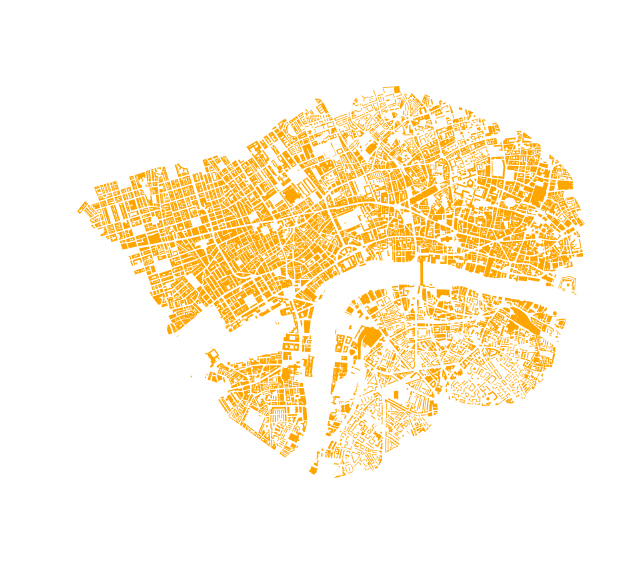

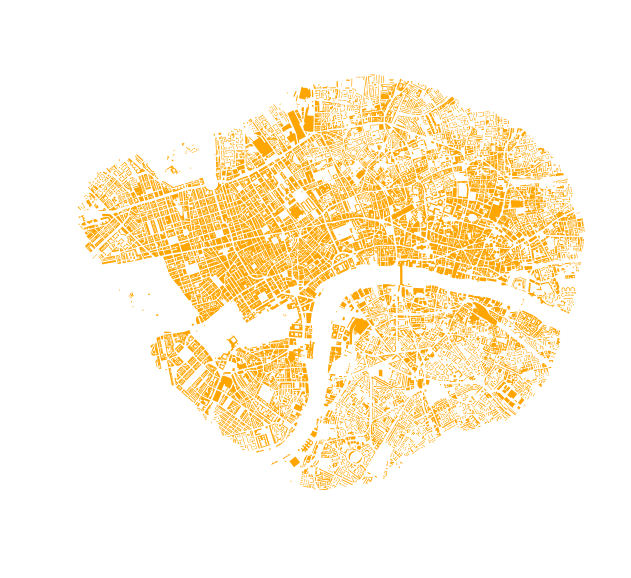

In [23]:
uf.plot_polygons(buildings)
uf.plot_polygons(obstructions)

In [ ]:
# to simplify 
# when a building is divided in several polygons import in QGIS --> dissolve, single to multipart, join attributes by location
# buildings.to_file(driver='ESRI Shapefile',filename="Outputs/tmp/building_to_dissolve.shp")
# load shapefile again
# buildings = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/Buildings/bh_26986_simplified.shp').to_crs(epsg=26986)

## 1 - Structural component

In [ ]:
%%time

streets = gpd.read_file("Outputs/"+city_name+"/"+city_name+"_paths.shp")
buildings = lf.structural_properties(buildings, obstructions, streets)

In [ ]:
%%time
buildings, vis = lf.advance_visibility_buildings(buildings, obstructions)

## 2 - Visual component

In [ ]:
buildings.to_file(driver='ESRI Shapefile',filename="Outputs/tmp/"+city_name+"_buildings_sight.shp")

In [ ]:
sight_lines = gpd.read_file("Outputs/"+city_name+"/"+city_name+"_sightlines_visible.shp")
sight_lines.head()

In [ ]:
buildings = ic.visibility(buildings, sight_lines)

## 3 - Cultural component

In [19]:
%%time
#load historical polygons

if city_name == 'Boston':
    directoryBoston = "C:/Users/g_filo01/sciebo/GIS Data/Boston/Buildings/Data_sources/other/historic_landmarks.shp"
    cultural_elements = (gpd.read_file(directoryBoston)).to_crs(epsg=epsg)
    buildings = ic.cultural_meaning(buildings, cultural_elements)

if city_name == 'London':
    directoryLondon = "C:/Users/g_filo01/sciebo/GIS Data/London/Historic_England/Listed_building_selection.shp"
    cultural_elements = (gpd.read_file(directoryLondon)).to_crs(epsg=epsg)
    cultural_elements['Grade'] = cultural_elements['Grade'].map( lambda x: 3 if x == 'I' else 2 if x == 'II*' else 1 
                                       if x == 'II' else 0)
    buildings = lf.cultural_meaning(buildings, cultural_elements, score = 'Grade')

Wall time: 17.6 s


## 4 - Pragmatic component

In [83]:
university = ['university', 'college', 'research']
commercial = ['bank', 'service',  'commercial',  'retail', 'Retail',  'pharmacy', 'commercial;educa', 'shop', 'Commercial',
                       'supermarket', 'offices', 'foundation', 'office', 'books', 'Commercial services']
residential = [ 'apartments', None, 'NaN', 'residential','flats', 'no', 'houses', 'garage', 'garages']
attractions = ['Attractions', 'museum',  'castle', 'cathedral', 'attraction','aquarium', 'monument',  'gatehouse',
               'terrace', 'tower', 'Attraction And Leisure']
hospitality = [ 'hotel',  'hostel', 'guest_house']
eating_drinking = [ 'restaurant', 'fast_food', 'cafe', 'bar',  'pub', 'Accommodation, eating and drinking',]
public = ['post_office', 'townhall', 'public_building',  'library','civic', 'courthouse', 'public', 'embassy',
          'Public infrastructure', 'community_centre', 'parking', 'dormitory']
library = ['library']
sport = ['stadium', 'Sport and entertainment', 'Sports Or Exercise Facility']
entertainment = [ 'exhibition_centr','theatre', 'cinema']
education = ['school', 'kindergarten', 'Education', 'Education and health']
religious = ['church', 'place_of_worship','convent', 'rectory', 'Religious Buildings']
emergency_service = [ 'fire_station','police', 'Emergency Service']
transport = [ 'station', 'train_station']
medical_care = ['hospital', 'doctors', 'dentist','clinic','veterinary', 'Medical Care']
industrial = [ 'industrial', 'factory', 'construction', 'Manufacturing and production',  'gasometer', 'data_center']
cultural = ['club_house','gallery', 'arts_centre','Cultural Facility']
military = ['general aviation', 'Barracks']
transport =['Transport', 'Road Transport', 'station', 'subway_entrance', 'bus_station']


drop = ['roof', 'garage', 'storage_tank', 'shed', 'silo',  'parking',  'toilets',,
  'picnic_site','hut', 'information',  'viewpoint', 'atm', 'building',  'tower',  'terrace',  'canopy', 'smokestack',  
 'greenhouse', 'fuel']

### London

In [31]:
# polygons
imp = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/London/OS OpenMap Local/TQ_ImportantBuilding2.shp')
fs = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/London/OS OpenMap Local/TQ_FunctionalSite.shp').to_crs(epsg = epsg)
stations = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/London/OS OpenMap Local/TQ_RailwayStation.shp').to_crs(epsg = epsg)
osm_buildings = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/London/OSM/buildings.shp').to_crs(epsg = epsg)
osm_buildings = osm_buildings[osm_buildings['type'] != None]

# points
POI = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/London/OS OpenMap Local/TQ_RailwayStation.shp') #from Ordnance Survey

In [75]:
%%time
gdf = [imp, fs, stations, osm_buildings]
columns_lu = ['BUILDGTHEM', 'SITETHEME', 'CLASSIFICA', 'type']
new_columns = ['land_use_1', 'land_use_2', 'land_use_3', 'land_use_4']

for i, p in enumerate(gdf):
    obstructions = lf.land_use_from_polygons(obstructions, p, new_columns[i], columns_lu[i])

TopologyException: Input geom 0 is invalid: Self-intersection at or near point 533793.26810412214 179574.13192187241 at 533793.26810412214 179574.13192187241
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 533793.26810412214 179574.13192187241 at 533793.26810412214 179574.13192187241
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 533793.26810412214 179574.13192187241 at 533793.26810412214 179574.13192187241
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 533793.26810412214 179574.13192187241 at 533793.26810412214 179574.13192187241
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 533793.26810412214 179574.13192187241 at 533793.26810412214 179574.13192187241
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 533793.26810412214 179574.13192187241 at 533793.26810412214 179574.13192187241
TopologyException: Input geom 0 is invalid: Self-int

TopologyException: Input geom 0 is invalid: Self-intersection at or near point 537663.65725940093 183363.98925880864 at 537663.65725940093 183363.98925880864
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 537663.65725940093 183363.98925880864 at 537663.65725940093 183363.98925880864
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 537663.65725940093 183363.98925880864 at 537663.65725940093 183363.98925880864
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 537663.65725940093 183363.98925880864 at 537663.65725940093 183363.98925880864
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 537663.65725940093 183363.98925880864 at 537663.65725940093 183363.98925880864
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 533733.82240547682 181019.0316041992 at 533733.82240547682 181019.0316041992
TopologyException: Input geom 0 is invalid: Self-inter

TopologyException: Input geom 0 is invalid: Self-intersection at or near point 533733.82240547682 181019.0316041992 at 533733.82240547682 181019.0316041992
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 533733.82240547682 181019.0316041992 at 533733.82240547682 181019.0316041992
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 533733.82240547682 181019.0316041992 at 533733.82240547682 181019.0316041992
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 533733.82240547682 181019.0316041992 at 533733.82240547682 181019.0316041992
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 533733.82240547682 181019.0316041992 at 533733.82240547682 181019.0316041992
TopologyException: Input geom 0 is invalid: Self-intersection at or near point 533733.82240547682 181019.0316041992 at 533733.82240547682 181019.0316041992
TopologyException: Input geom 0 is invalid: Self-intersection at

Wall time: 9min 31s


In [57]:
%%time
gdf = [POI]
columns_lu = ['main']
new_columns = ['land_use_5']

for i, p in enumerate(gdf):
    obstructions = lf.land_use_from_points(obstructions, p, new_columns[i], columns_lu[i])

Wall time: 1min 19s


In [77]:
obstructions['land_use_1'][obstructions['land_use_1'] == 'NaN'] = obstructions['land_use_2']
obstructions['land_use_1'][obstructions['land_use_1'] == 'NaN'] = obstructions['land_use_3']
obstructions['land_use_1'][obstructions['land_use_1'] == 'NaN'] = obstructions['land_use_5']
obstructions['land_use_1'][obstructions['land_use_1'] == 'NaN'] = obstructions['land_use_4']
obstructions.head()

,OBJECTID,Join_Count,TARGET_FID,height,base,area,buildingID,Shape_Leng,Shape_Area,geometry,land_use_1,land_use_2,land_use_3,land_use_4,land_use_5
0,1,0,0,3.180,0,208.221,0,70.248,208.221,"POLYGON ((529891.79 183628.2200000007, 529898....",Transport,NaN,NaN,NaN,Transport
1,2,0,1,12.210,0,942.013,0,211.712,942.013,"POLYGON ((529908.4400000004 183173.1600000001,...",None,NaN,NaN,None,NaN
2,3,0,2,12.270,0,331.740,0,87.313,331.740,"POLYGON ((529866.5 183238.3499999996, 529847.9...",Commercial services,NaN,NaN,None,Commercial services
3,4,0,3,27.820,0,1637.525,0,304.349,1637.525,"POLYGON ((527543.29 182478.7400000002, 527460....",Attractions,NaN,NaN,NaN,Attractions
4,5,0,4,11.590,0,1441.718,0,184.662,1441.718,"POLYGON ((527005.8700000001 182333.7400000002,...",Education,Education,NaN,NaN,Education and health


In [84]:
obstructions['land_use_1'] = obstructions['land_use_1'].map( lambda x: 'university' if x in university
                                                          else 'commercial' if x in commercial
                                                          else 'residential' if x in residential
                                                          else 'attractions' if x in attractions
                                                          else 'library' if x in library
                                                          else 'hospitality' if x in hospitality
                                                          else 'eating_drinking' if x in eating_drinking
                                                          else 'public' if x in public
                                                          else 'sport' if x in sport
                                                          else 'entertainment' if x in entertainment
                                                          else 'education' if x in education
                                                          else 'religious' if x in religious
                                                          else 'emergency_service' if x in emergency_service
                                                          else 'industrial' if x in industrial
                                                          else 'cultural' if x in cultural
                                                          else 'transport' if x in transport
                                                          else 'medical_care' if x in medical_care
                                                          else 'military' if x in military
                                                          else x)

obstructions.land_use_1.unique()

array(['transport', 'residential', 'commercial', 'attractions',
       'education', 'public', 'religious', 'eating_drinking', 'industrial',
       'sport', 'emergency_service', 'cultural', 'medical_care',
       'hospitality', 'military'], dtype=object)

In [87]:
obstructions['land_use'] = obstructions['land_use_1']
obstructions.drop(['land_use_1', 'land_use_2', 'land_use_3', 'land_use_4', 'land_use_5'], axis = 1, inplace = True)

### Boston

In [ ]:
# loading polygons data

parcels = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/Buildings/Data_sources/Parcels_2016/parcels.shp').to_crs(epsg = epsg)
osm_buildings = gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/OSM/buildings.shp').to_crs(epsg = epsg)
osm_buildings = osm_buildings[osm_buildings['type'] != None]

In [ ]:
%%time
gdf = [parcels, osm_buildings]
columns_lu = ['LU', 'type']
new_columns = ['land_use_1', 'land_use_2']
for i, p in enumerate(gdf):
    obstructions = lf.land_use_from_polygons(obstructions, p, new_columns[i], columns_lu[i])

In [ ]:
residential_b = ['Residential Condo Unit', 'Apartments 4-6 Units', 'Residential Two Family', 
               'Apartments 7 Units above', 'Residential Single Family', 'Condominium Parking', 'Residential Three Family',
               'Condominium Master', 'Residential Land']
commercial_b = ['Commercial', 'Commercial Land', 'Mixed Use Res/Comm',  'Commercial Condo Unit']
public_b = ['Exempt', 'Exempt 121A']

obstructions['land_use_1'] = obstructions['land_use_1'].map( lambda x: 'residential' if x in residential_b
                                                          else 'commercial' if x in commercial_b
                                                          else 'public' if x in public_b
                                                          else 'industrial' if x == 'Industrial'
                                                          else x)

In [ ]:
obstructions['land_use_1'] = obstructions['land_use_1'].map( lambda x: 'university' if x in university
                                                          else 'commercial' if x in commercial
                                                          else 'residential' if x in residential
                                                          else 'attractions' if x in attractions
                                                          else 'library' if x in library
                                                          else 'hospitality' if x in hospitality
                                                          else 'eating_drinking' if x in eating_drinking
                                                          else 'public' if x in public
                                                          else 'sport' if x in sport
                                                          else 'entertainment' if x in entertainment
                                                          else 'education' if x in education
                                                          else 'religious' if x in religious
                                                          else 'emergency_service' if x in emergency_service
                                                          else 'industrial' if x in industrial
                                                          else 'cultural' if x in cultural
                                                          else 'transport' if x in transport
                                                          else 'medical_care' if x in medical_care
                                                          else 'military' if x in military
                                                          else x)

obstructions.land_use_1.unique()

#### Other data from Boston

In [ ]:
# libraries and schools

schools = (gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/Buildings/Data_sources/other/schools.shp'
                        ).to_crs(epsg=26986))

universities = (gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/Buildings/Data_sources/other/universities.shp'
                        ).to_crs(epsg=26986))

p_schools = (gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/Buildings/Data_sources/other/private_schools.shp'
                        ).to_crs(epsg=26986))

libraries = (gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/Buildings/Data_sources/other/libraries.shp'
                        ).to_crs(epsg=26986))

pools = (gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/Buildings/Data_sources/other/pools.shp'
                        ).to_crs(epsg=26986))

police = (gpd.read_file('C:/Users/g_filo01/sciebo/GIS Data/Boston/Buildings/Data_sources/other/police_stations.shp'
                        ).to_crs(epsg=26986))

In [ ]:
%%time

df_list = [schools, p_schools, libraries, universities, pools, police]
classification = ['education', 'education', 'library', 'university', 'sport', 'emergency_service']

index_geometry = obstructions.columns.get_loc("geometry")+1 
index_land_use = obstructions.columns.get_loc("land_use_1")+1
list_lu = ['residential', 'commercial', 'NaN']

for i, t in enumerate(df_list):
    sindex = t.sindex

    for row in obstructions.itertuples():
        g = row[index_geometry] #geometry
    
        possible_matches_index = list(sindex.intersection(g.bounds))
        possible_matches = t.iloc[possible_matches_index]
        precise_matches = possible_matches[possible_matches.intersects(g)]
                
        if (len(precise_matches)==0): continue
        if (row[index_land_use] not in list_lu): continue
        else: obstructions.set_value(row[0], 'land_use_1', classification[i])

In [ ]:
obstructions['land_use_1'][obstructions['land_use_1'] == 'NaN'] = obstructions['land_use_2']
obstructions['land_use'] = obstructions['land_use_1']
obstructions.drop(['land_use_1', 'land_use_2', 'land_use_3', 'land_use_4', 'land_use_5'], axis = 1, inplace = True)
obstrucions.head()

### Pragmatic meaning computation

In [95]:
%%time
obstructions = lf.pragmatic_meaning(obstructions)
buildings = pd.merge(buildings, obstructions[['prag', 'land_use', 'buildingID']], how = 'left', 
                     left_on = "buildingID", right_on = "buildingID")

Wall time: 27.1 ms


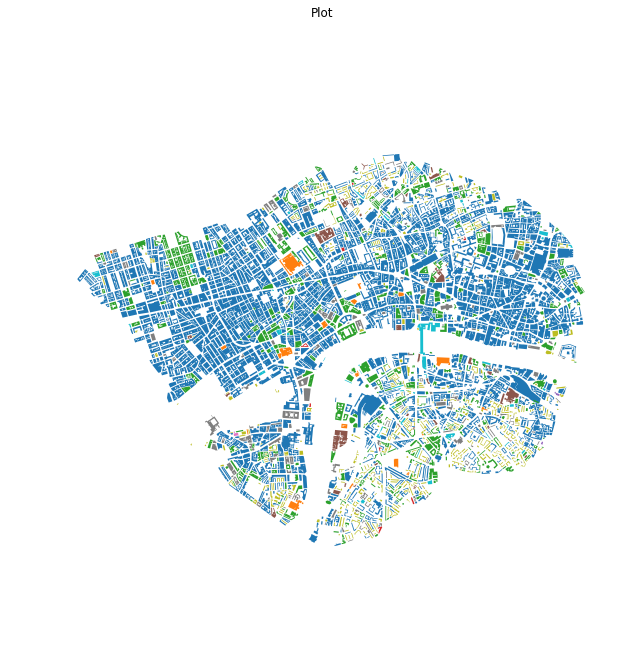

In [106]:
uf.plot_polygons(buildings, column = 'land_use', black_back = False)

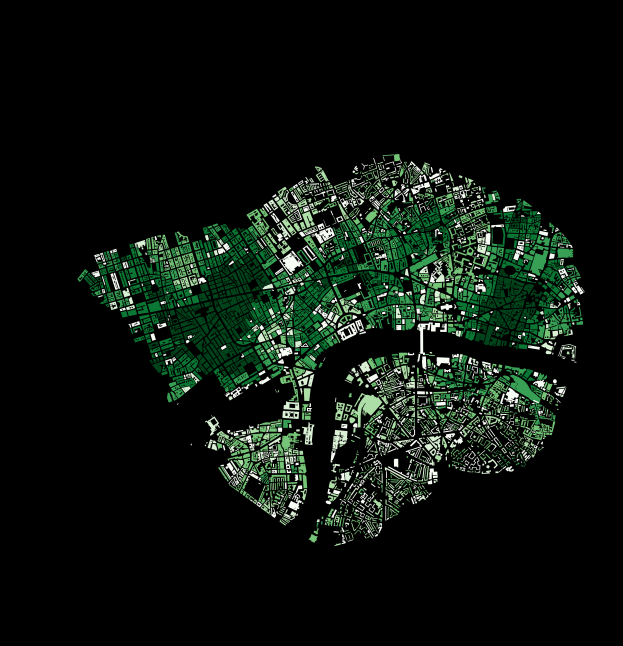

In [108]:
uf.plot_polygons(buildings, column = 'prag', scheme = 'fisher_jenks', black_back = True)

# 5 - Final scores

In [ ]:
buildings = ic.compute_scores(buildings)
buildings.crs = crs

In [ ]:
buildings.to_file(driver='ESRI Shapefile',filename="Outputs/"+city_name+"/"+city_name+"_landmarks.shp")